In [24]:
# Import required libraries
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<Axes: xlabel='Date'>

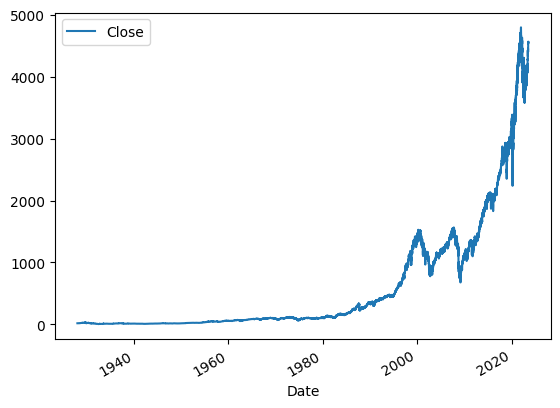

In [25]:
# Getting historical data for stock / index
stock = yf.Ticker("^GSPC")
stock = stock.history(period="max")
stock.plot.line(y="Close", use_index=True)

In [26]:
# Removing dividends and stock splits columns
del stock["Dividends"]
del stock["Stock Splits"]

# New column indicates if tomorrow's closing price > today's
stock["Tomorrow"] = stock["Close"].shift(-1)
stock["Target"] = (stock["Tomorrow"] > stock["Close"]).astype(int)

# Using recent data due to market shift
stock = stock.loc["1990-01-01":].copy()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-07-18 00:00:00-04:00,4521.779785,4562.299805,4514.589844,4554.979980,4090010000,4565.720215,1
2023-07-19 00:00:00-04:00,4563.870117,4578.430176,4557.479980,4565.720215,4115670000,4534.870117,0
2023-07-20 00:00:00-04:00,4554.379883,4564.740234,4527.560059,4534.870117,3761770000,4536.339844,1


In [27]:
# Train the model and classify predictions as 1 or 0 based on probability threshold
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [28]:
# Function to backtest the model with a rolling window
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [29]:
# New variables using different time horizons
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
  rolling_averages = stock.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  stock[ratio_column] = stock["Close"] / rolling_averages["Close"]

  trend_column = f"Trend_{horizon}"
  stock[trend_column] = stock.shift(1).rolling(horizon).sum()["Target"]

  new_predictors += [ratio_column, trend_column]

In [30]:
# Dropping rows with missing values
stock = stock.dropna()

In [31]:
# Initializing Random Forest model
model = RandomForestClassifier(n_estimators=300, min_samples_split=50, random_state=1)

In [32]:
# Running the backtest
predictions = backtest(stock, model, new_predictors)

In [33]:
# Counting the number of 0's and 1's in the predictions
predictions["Predictions"].value_counts()

Predictions
0.0    4167
1.0     786
Name: count, dtype: int64

In [34]:
# Calculating the precision score
precision_score(predictions["Target"], predictions["Predictions"])

0.5687022900763359

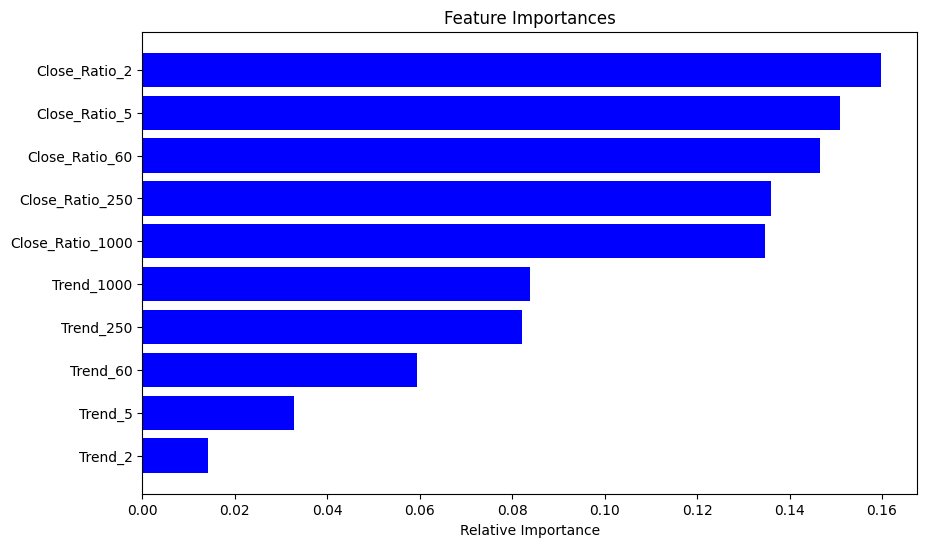

In [35]:
# Feature Importance Bar Plot
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [new_predictors[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


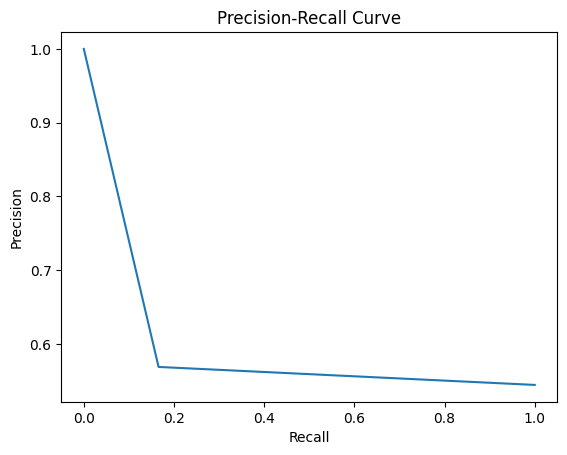

In [36]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(predictions["Target"], predictions["Predictions"])
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


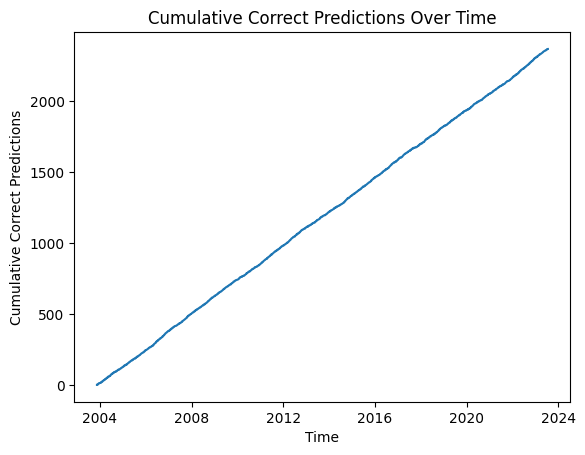

In [37]:
predictions['Correct Predictions'] = predictions['Target'] == predictions['Predictions']
predictions['Correct Predictions'] = predictions['Correct Predictions'].astype(int)
predictions['Strategy Equity'] = predictions['Correct Predictions'].cumsum()

plt.plot(predictions.index, predictions['Strategy Equity'])
plt.xlabel('Time')
plt.ylabel('Cumulative Correct Predictions')
plt.title('Cumulative Correct Predictions Over Time')
plt.show()

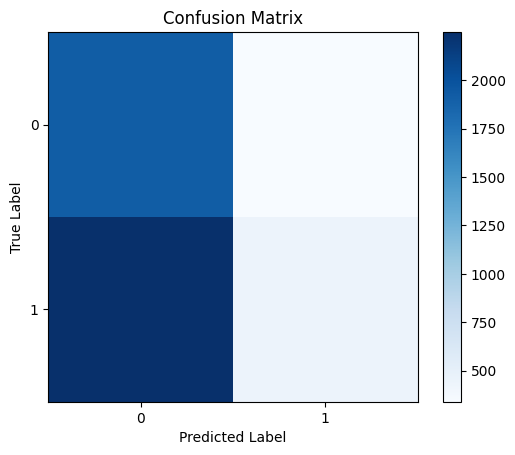

In [38]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
cm = confusion_matrix(predictions["Target"], predictions["Predictions"])
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], labels=["0", "1"])
plt.yticks([0, 1], labels=["0", "1"])
plt.show()

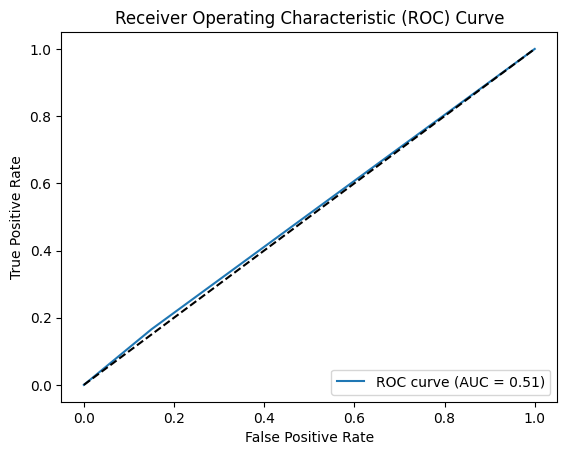

In [39]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(predictions["Target"], predictions["Predictions"])
roc_auc = roc_auc_score(predictions["Target"], predictions["Predictions"])
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
stock = stock.dropna()
stock

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17 00:00:00-04:00,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,4554.979980,1,1.001924,1.0,1.007318,4.0,1.060553,33.0,1.121161,121.0,1.188390,533.0
2023-07-18 00:00:00-04:00,4521.779785,4562.299805,4514.589844,4554.979980,4090010000,4565.720215,1,1.003546,2.0,1.009285,4.0,1.066329,34.0,1.128448,121.0,1.196367,533.0
2023-07-19 00:00:00-04:00,4563.870117,4578.430176,4557.479980,4565.720215,4115670000,4534.870117,0,1.001178,2.0,1.007487,4.0,1.067044,34.0,1.130431,121.0,1.198702,534.0


In [54]:
# Copy the DataFrame
stock_copy = stock.copy()

# Calculate daily returns
stock_copy["Returns"] = stock_copy["Close"].pct_change()

# Assuming you have trained your model and obtained predictions
predictions = model.predict(stock[new_predictors])

# Add the predictions to the DataFrame
stock_copy["Predictions"] = predictions

# Calculate cumulative returns
stock_copy["Cumulative Returns"] = stock_copy["Returns"].cumsum()

# Construct strategy returns
stock_copy["Strategy Returns"] = stock_copy["Returns"] * stock_copy["Predictions"].shift()

# Calculate cumulative strategy returns
stock_copy["Cumulative Strategy Returns"] = stock_copy["Strategy Returns"].cumsum()

# Calculate annualized returns
start_date = stock_copy.index[0]
end_date = stock_copy.index[-1]
total_days = (end_date - start_date).days
total_years = total_days / 365

# Calculate strategy-based annualized return
total_strategy_return = stock_copy["Cumulative Strategy Returns"].iloc[-1]
average_annual_strategy_return = (total_strategy_return ** (1 / total_years) - 1) * 100

# Calculate Sharpe Ratio
risk_free_rate = 0.03  # Assuming a risk-free rate of 3%
strategy_returns = stock_copy["Strategy Returns"].dropna()
excess_strategy_returns = strategy_returns - risk_free_rate / 252
annualized_excess_strategy_return = np.mean(excess_strategy_returns) * 252
annualized_strategy_volatility = strategy_returns.std() * np.sqrt(252)  # Assuming 252 trading days in a year
strategy_sharpe_ratio = annualized_excess_strategy_return / annualized_strategy_volatility

# Calculate Strategy Maximum Drawdown
stock_copy["Strategy Peak"] = stock_copy["Cumulative Strategy Returns"].cummax()
stock_copy["Strategy Drawdown"] = (stock_copy["Cumulative Strategy Returns"] - stock_copy["Strategy Peak"]) / stock_copy["Strategy Peak"]
strategy_max_drawdown = stock_copy["Strategy Drawdown"].min() * 100

# Calculate number of trades
trades = np.diff(stock_copy["Predictions"].values)
number_of_trades = np.sum(np.abs(trades))

# Print the results
print(f"Average Annual Strategy Return: {average_annual_strategy_return:.2f}%")
print(f"Strategy Sharpe Ratio: {strategy_sharpe_ratio:.2f}")
print(f"Strategy Maximum Drawdown: {strategy_max_drawdown:.2f}%")
print(f"Number of Trades: {number_of_trades}")


Average Annual Strategy Return: 11.00%
Strategy Sharpe Ratio: 5.21
Strategy Maximum Drawdown: -59.77%
Number of Trades: 3347


In [42]:
stock_copy = stock_copy.dropna()
stock_copy

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Trend_250,Close_Ratio_1000,Trend_1000,Returns,Cumulative Returns,Predictions,Strategy Returns,Cumulative Strategy Returns,Strategy Peak,Strategy Drawdown
Date,,,,,,,,,,,,,,,,,,,,,
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,...,126.0,1.172676,512.0,-0.002635,0.997365,1,-0.002635,9.973653e-01,9.973653e-01,0.000000
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,...,127.0,1.176163,513.0,0.003248,1.000605,1,0.003248,1.000605e+00,1.000605e+00,0.000000
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,...,128.0,1.183537,514.0,0.006561,1.007170,1,0.006561,1.007170e+00,1.007170e+00,0.000000
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,...,128.0,1.181856,513.0,-0.001136,1.006025,1,-0.001136,1.006025e+00,1.007170e+00,-0.001136
1993-12-21 00:00:00-05:00,465.839996,465.920013,464.029999,465.299988,273370000,467.320007,1,0.999409,0.0,1.001632,...,127.0,1.180115,513.0,-0.001181,1.004837,1,-0.001181,1.004837e+00,1.007170e+00,-0.002316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-17 00:00:00-04:00,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,4554.979980,1,1.001924,1.0,1.007318,...,121.0,1.188390,533.0,0.003855,9.767179,0,0.000000,2.590390e+09,2.590390e+09,0.000000
2023-07-18 00:00:00-04:00,4521.779785,4562.299805,4514.589844,4554.979980,4090010000,4565.720215,1,1.003546,2.0,1.009285,...,121.0,1.196367,533.0,0.007117,9.836695,0,0.000000,2.590390e+09,2.590390e+09,0.000000
2023-07-19 00:00:00-04:00,4563.870117,4578.430176,4557.479980,4565.720215,4115670000,4534.870117,0,1.001178,2.0,1.007487,...,121.0,1.198702,534.0,0.002358,9.859889,0,0.000000,2.590390e+09,2.590390e+09,0.000000
